In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_raw
import matplotlib.pyplot as plt_hist
import matplotlib.pyplot as plt_perievent_traces

# for resampling data
from scipy import signal

In [2]:
#. Input Deconv Data

# Target_Frame_Rate will be 20   #. This is same as the 20 frames/second for Ca Imaging  (Resample Rate )

Save_Path = '/Users/kang/Documents/GitHub/Imaging Analysis/Motion_Extraction/Put_Videos_Here/'
File_Path = '/Users/kang/Documents/GitHub/Imaging Analysis/Motion_Extraction/Put_Videos_Here/'


#File_Name = 'Ka-DS3-P5_5-S7-Water_MotionExtract_NotAlign_Step1.csv'   
File_Name = '5_2022-10-08_13-37-08-Ka-DS12-P5_5-S6-Water_MotionExtract_NotAlign_Step1.csv'   
Real_Session_Len = 1 + 48000 # 1 + is for starting at 0 


In [3]:
df_temp = pd.read_csv((File_Path+'/'+File_Name), low_memory=False)
df = df_temp[['Motion', 'Light_1', 'Light_2', 'Light_3']].copy()


In [4]:
print(df_temp.keys())

print(df)


Index(['Motion',
       'original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)',
       'Light_1', 'Light_2', 'Light_3'],
      dtype='object')
       Motion     Light_1     Light_2    Light_3
0         0.0    0.000000    0.000000   0.000000
1       732.0  110.507360  116.700240  82.901638
2       242.0  110.456333  116.715994  82.896696
3       248.0  110.456333  116.715994  82.896696
4        22.0  110.456333  116.715994  82.740030
...       ...         ...         ...        ...
73584     0.0  107.812432  116.826556  78.402896
73585     6.0  107.812432  116.826556  78.402896
73586     0.0  107.812432  116.826556  78.402896
73587     0.0  107.812432  116.826556  78.402896
73588     2.0  107.812432  116.826556  78.402896

[73589 rows x 4 columns]


In [5]:
# #Repair 5s Pluse

# #assign a range to be a fixed value 
# Begin_Interval= 1900
# End_Interval = 1950
# df['Light_2'][Begin_Interval : End_Interval]= [125]*(End_Interval -Begin_Interval)


In [6]:
df_temp['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)'][9] = File_Name
df_temp['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)'][10] = (Real_Session_Len-1)  # Session Duration




/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_22512/181181958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)'][9] = File_Name
/var/folders/2c/qcjtsn_j1xngx_g__j1y_rn00000gn/T/ipykernel_22512/181181958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)'][10] = (Real_Session_Len-1)  # Session Duration


In [7]:
# Threshold to detect Signal Light_1, Light_2, Light_3

Threshold_Light_1 = 175
Threshold_Light_2 = 175
Threshold_Light_3 = 150

#. These thresholds needs to be idential to the threshold above 
Threshold_Aligned_Motion = 0   #. Any value below this value gets set to 0 
Threshold_Aligned_Light_1 = 175
Threshold_Aligned_Light_2 = 175
Threshold_Aligned_Light_3 = 150



# Threshold_Light_1 = 0.5
# Threshold_Light_2 = 0.5
# Threshold_Light_3 = 0.5


# #Test_animal Ka-DS1-P5_5-S38-Sucrose_Motion
# Threshold_Light_1 = 100
# Threshold_Light_2 = 120
# Threshold_Light_3 = 125


# Signal_Light_1 = zeros(len(df['Light_1']))
# Signal_Light_2 = zeros(len(df['Light_2']))
# Signal_Light_3 = zeros(len(df['Light_3']))


# 

signal_Length = len(df)
#x_axis = np.arange(0,signal_Length) 
Signal_Light_1 = np.asarray( [0]*signal_Length)
Signal_Light_1 = [1 if i> Threshold_Light_1 else 0 for i in df['Light_1']] 

Signal_Light_2 = np.asarray( [0]*signal_Length)
Signal_Light_2 = [1 if i> Threshold_Light_2 else 0 for i in df['Light_2']] 

Signal_Light_3 = np.asarray( [0]*signal_Length)
Signal_Light_3 = [1 if i> Threshold_Light_3 else 0 for i in df['Light_3']] 


# Find Imaging Onset Time in frames using Signal_Light_1
res = list(filter(lambda i: i > 0.5, Signal_Light_1))[0]
Image_Onset =  Signal_Light_1.index(res)


# Find Imaging Offset Time in frames using Signal_Light_1
# by fliping Signal_Light front and end, and look for last time when signal was still on.  
Flipped_Signal_Light_1 = list(reversed(Signal_Light_1))
res = list(filter(lambda i: i > 0.5, Flipped_Signal_Light_1))[0]
Image_Offset =  len(Signal_Light_1)- Flipped_Signal_Light_1.index(res)





#  Duration in frames

Image_Duration = Image_Offset - Image_Onset +1

# Find 5 seconds on/off Time in frames using Signal_Light_2

counter = 0
Five_Second_On_Off_Trace = np.asarray( [0]*len(df))
Five_Second_On_Off_Count = 0
Five_Second_On_Off = defaultdict(list)
Five_Second_On_Off['Duration'].append(None)
Five_Second_On_Off['Time_Stamp'].append(None)

for i in range(len(df)-1):
    if(Signal_Light_2[i] == Signal_Light_2[i+1]):
        counter = counter +1
    elif(Signal_Light_2[i] != Signal_Light_2[i+1]):
        Five_Second_On_Off['Duration'].append(counter+1)
        Five_Second_On_Off['Time_Stamp'].append(i+1)
        Five_Second_On_Off_Count = Five_Second_On_Off_Count+1
        counter = 0                                       # reset counter
#. add session (Light_1) offset timestamp into Five_Second_On_Off, (the offset pulse does not give timestamps)
Last_5s_Stamp = Five_Second_On_Off['Time_Stamp'][Five_Second_On_Off_Count]

Five_Second_On_Off['Time_Stamp'].append(Image_Offset)

Five_Second_On_Off['Duration'].append(Image_Offset-Last_5s_Stamp)
Five_Second_On_Off_Count = Five_Second_On_Off_Count+1

        
#  Remove 'None' place holder for Event_Count_TimeStamp, which is the first value
del Five_Second_On_Off['Duration'][0]
del Five_Second_On_Off['Time_Stamp'][0]

# print(Five_Second_On_Off_Count)
# print(Five_Second_On_Off)

for i in range(Five_Second_On_Off_Count):
    tempa = Five_Second_On_Off['Time_Stamp'][i]
    #tempa = int(tempa[0])   # Convert to Integer
    Five_Second_On_Off_Trace[tempa:tempa+1] = [1]





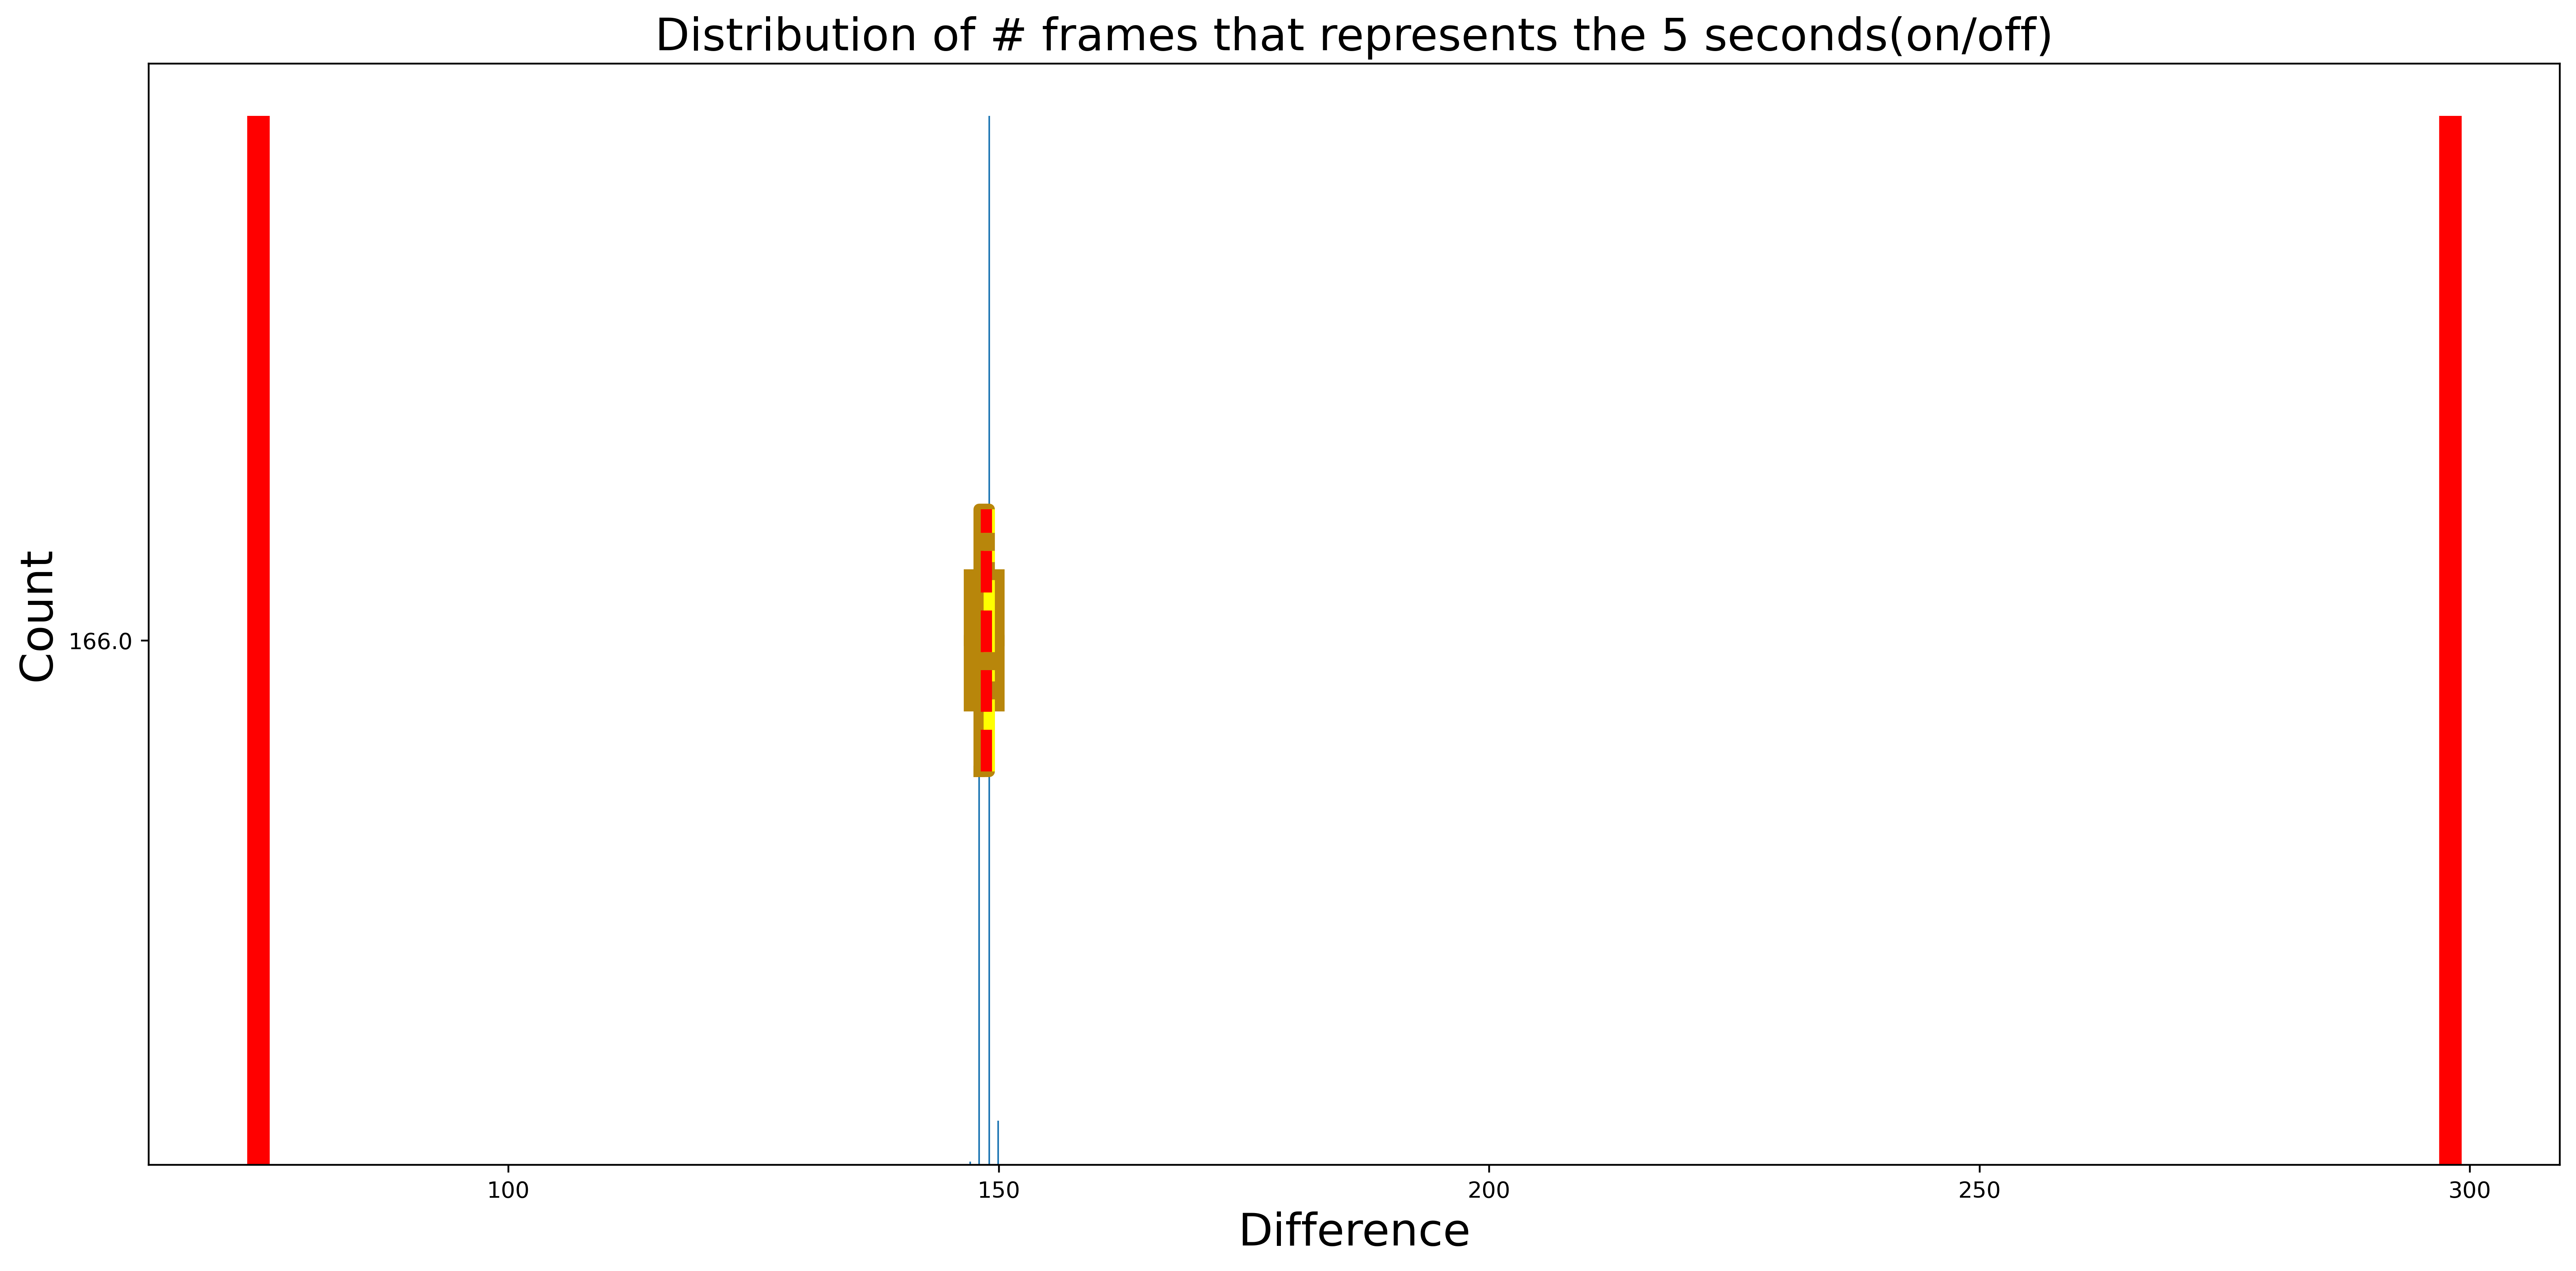

Image Duration in Frames (after accounting for Begin and End Time):    71400
Median Duration of 5s pulse in Frames:    149.0
Maximum 150
Minimum 147
Estimated Frame Rate:    29.8
Estimated number of 5s pulse:    479.19463087248323
Actual number of 5s pulse:    481


In [8]:
#print(Five_Second_On_Off)

# Find averaged duration of 5s on/off

############################
##.  Histogram
#####################
fig = plt_hist.figure(figsize =(19.2, 19.8), dpi = 400.0)
ax = fig.add_subplot(2,1 ,1)


n_bins = 20


#dist = [ -10, 20, 10, 90, 95, 90, 90, 0 , 4]  #. Before minus After
dist = Five_Second_On_Off['Duration'][1:Five_Second_On_Off_Count]   #. Omit first value (which is Ca Imaging start)
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt_hist.hist(dist, bins=n_bins)
plt_hist.title(('Distribution of # frames that represents the 5 seconds(on/off)'), fontdict=None, loc='center', size = 20)
plt_hist.ylabel('Count', size = 20)
plt_hist.xlabel('Difference', size = 20)
#plt_hist.bar_label(patches)
#print(max(n))   #. max for y axis (important for box plot position)

#. Anything that goes beyond 2 times the median duration for 5 second pulse indicates missing timestamps 
#. Anything that goes under 1/2 the median duration for 5 second pulse indicates noise contimation in 5 second pulse 
ax.vlines(x= np.median(dist)*2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')
ax.vlines(x= np.median(dist)/2, ymin=0, ymax=max(n), colors='red', lw=10, label='vline_single - partial height')




Position_one_label = 'Veh-Baseline'

# Box plot Settings
boxprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,linestyle='none')
medianprops = dict(linestyle='-.', linewidth=5, color='Yellow')
meanpointprops = dict(marker='D', markeredgecolor='red',markerfacecolor='red')
meanlineprops = dict(linestyle='--', linewidth=5, color='red')
whiskerprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')
capprops = dict(linestyle='-', linewidth=5, color='darkgoldenrod')

plt_perievent_traces.boxplot(dist, showmeans=True, meanline = True, positions=[max(n)/2], widths = max(n)/4, boxprops=boxprops,  meanprops=meanlineprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, vert=False) #red is mean,  green is median
plt_perievent_traces.show()





Five_Second_On_Off_Median_Dur = np.median(dist)
Estimated_Count = Image_Duration/Five_Second_On_Off_Median_Dur
Estimated_Avg_FrameRate = Five_Second_On_Off_Median_Dur/5

print('Image Duration in Frames (after accounting for Begin and End Time):   ', Image_Duration)
print('Median Duration of 5s pulse in Frames:   ', Five_Second_On_Off_Median_Dur)
print('Maximum', max(dist))
print('Minimum', min(dist))

print('Estimated Frame Rate:   ', Estimated_Avg_FrameRate)
print('Estimated number of 5s pulse:   ', Estimated_Count)
print('Actual number of 5s pulse:   ', Five_Second_On_Off_Count)



In [9]:
# print(Five_Second_On_Off['Time_Stamp'][0])
# print(Five_Second_On_Off['Time_Stamp'][1])

print(Five_Second_On_Off)
# print(Five_Second_On_Off['Time_Stamp'][len(Five_Second_On_Off['Time_Stamp'])-1])

#print(len(Five_Second_On_Off['Time_Stamp'])-1)

defaultdict(<class 'list'>, {'Duration': [1315, 149, 149, 149, 149, 148, 149, 149, 148, 149, 149, 149, 148, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 148, 149, 148, 150, 148, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 148, 149, 149, 149, 148, 149, 148, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 148, 149, 149, 149, 148, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 148, 150, 148, 149, 149, 148, 149, 149, 149, 148, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 148, 149, 149, 149, 148, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 149, 148, 149, 149, 149, 148, 149, 149, 149, 148, 149, 148, 150, 148, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 148, 149, 149, 148, 149, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 149, 148, 149, 149, 149, 148, 149, 149, 149, 148, 149, 149, 149, 148, 149, 149, 148, 150, 14

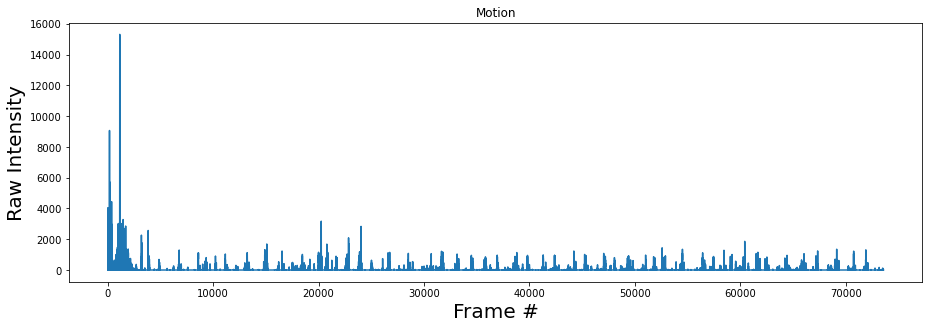

In [10]:
# Plot Motion
plt_raw.plot(df['Motion'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Motion', fontdict=None, loc='center')
plt_raw.show()

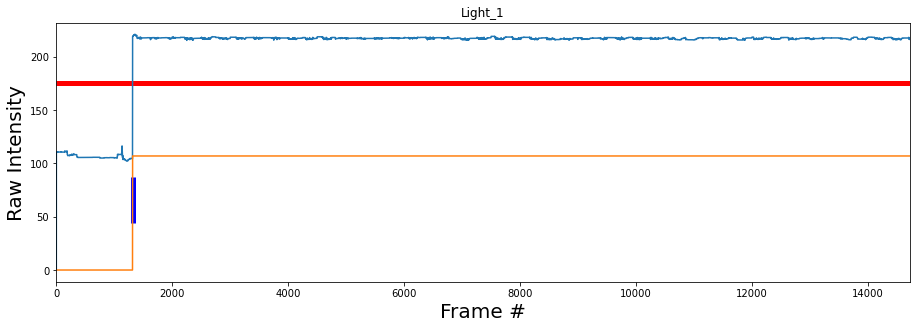

Image Onset in Frames =  1315


In [11]:
# Plot Light_1  for Session Begin

# Draw Threshold Line
plt_raw.hlines(y= Threshold_Light_1, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
# Draw Image_Onset Line
plt_raw.vlines(x= Image_Onset, ymin=Threshold_Light_1/4, ymax=Threshold_Light_1/2, colors='blue', lw=5, label='vline_single - partial height')


plt_raw.plot(df['Light_1'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

temp_signal_min =np.mean(df['Light_1'])                 
display = [x *temp_signal_min*0.5 for x in Signal_Light_1]
plt_raw.plot(display)
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Light_1', fontdict=None, loc='center')
plt_raw.xlim(0, len(df)/5)
plt_raw.show()

print('Image Onset in Frames = ', str(Image_Onset))

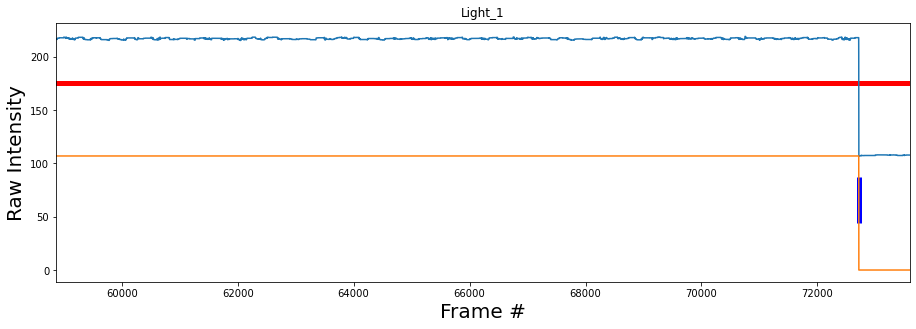

Image Offset in Frames =  72714


In [12]:
# Plot Light_1 for Session End

# Draw Threshold Line
plt_raw.hlines(y= Threshold_Light_1, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
# Draw Image_Onset Line
plt_raw.vlines(x= Image_Offset, ymin=Threshold_Light_1/4, ymax=Threshold_Light_1/2, colors='blue', lw=5, label='vline_single - partial height')


plt_raw.plot(df['Light_1'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

temp_signal_min =np.mean(df['Light_1'])                 
display = [x *temp_signal_min*0.5 for x in Signal_Light_1]
plt_raw.plot(display)
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Light_1', fontdict=None, loc='center')
plt_raw.xlim(len(df)/5*4, len(df))
plt_raw.show()

print('Image Offset in Frames = ', str(Image_Offset))

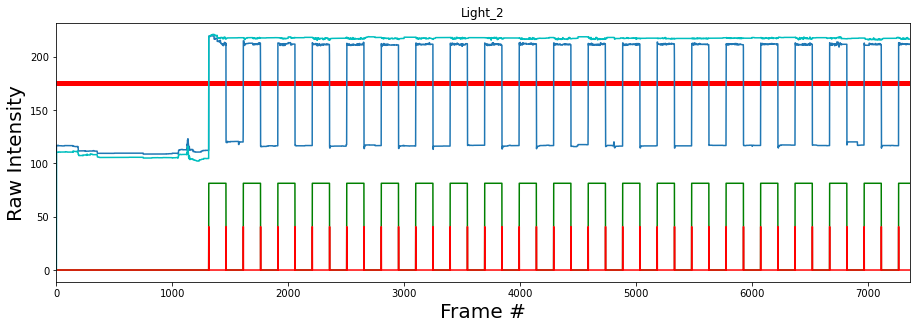

In [13]:
# Plot Light_2

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Light_2, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
# plt_perievent_traces.xticks(np.arange(-1, (WindowBeging +WindowEnd +1), 5))
# plt_perievent_traces.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))


plt_raw.plot(df['Light_2'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

temp_signal_min =np.mean(df['Light_2'])                 
Light_2_display = [x *temp_signal_min*0.5 for x in Signal_Light_2]
plt_raw.plot(Light_2_display, 'green')

Five_Second_On_Off_Trace_display = [x *temp_signal_min*0.25 for x in Five_Second_On_Off_Trace]
plt_raw.plot(Five_Second_On_Off_Trace_display, 'red')

plt_raw.plot(df['Light_1'],'c')



plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Light_2', fontdict=None, loc='center')
plt_raw.xlim(0, len(df)/10)
#plt_raw.xlim(0, len(df))
#plt_raw.xlim(len(df)/10*9, len(df))
plt_raw.show()

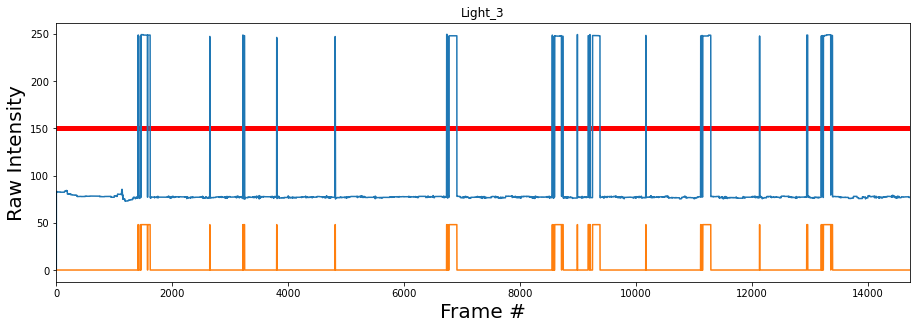

In [14]:
# Plot Light_3

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Light_3, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
# plt_perievent_traces.xticks(np.arange(-1, (WindowBeging +WindowEnd +1), 5))
# plt_perievent_traces.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))


plt_raw.plot(df['Light_3'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

temp_signal_min =np.mean(df['Light_3'])                 
display = [x *temp_signal_min*0.5 for x in Signal_Light_3]
plt_raw.plot(display)
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Light_3', fontdict=None, loc='center')
plt_raw.xlim(0, len(df)/5)
plt_raw.show()

In [15]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html
# Web Example
# x = np.linspace(0, 10, 20, endpoint=False)
# y = np.cos(-x**2/6.0)
# f = signal.resample(y, 100)
# xnew = np.linspace(0, 10, 100, endpoint=False)

# plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
# plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0])
# plt.legend(['data', 'resampled'], loc='best')
# plt.show()

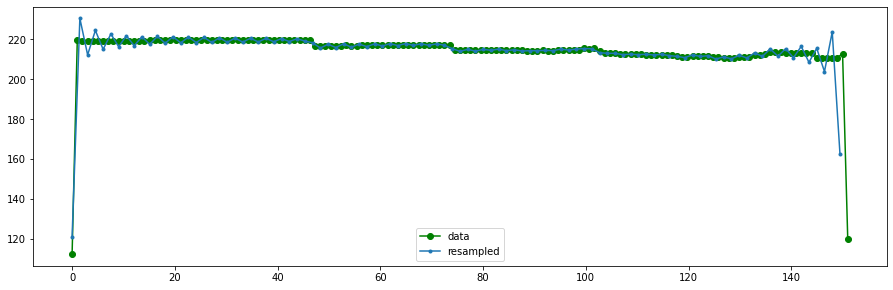

151
100


In [16]:
#. Check individual 5s time pulse 
d = df['Light_2'][Five_Second_On_Off['Time_Stamp'][0]-1 : Five_Second_On_Off['Time_Stamp'][1]+1]    #. DO NOT COPY THIS


x = np.linspace(0, len(d), len(d))

# #y = np.cos(-x**2/6.0)
f = signal.resample(d, 100)
xnew = np.linspace(0, len(d), 100, endpoint=False)

# import matplotlib.pyplot as plt
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt.plot(x, d, 'go-', xnew, f, '.-')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

print(len(d))
print(len(f))

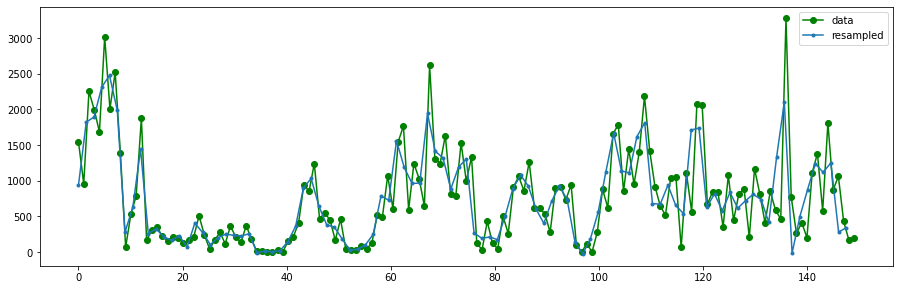

Original:   149
Resampled:   100


In [17]:
# resample 
#. Motion of specific 5 second block 
    
d = df['Motion'][Five_Second_On_Off['Time_Stamp'][0] : Five_Second_On_Off['Time_Stamp'][1]]


x = np.linspace(0, len(d), len(d))

# #y = np.cos(-x**2/6.0)
f = signal.resample(d, 100)
xnew = np.linspace(0, len(d), 100, endpoint=False)

# import matplotlib.pyplot as plt
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt.plot(x, d, 'go-', xnew, f, '.-')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

print('Original:  ',len(d))
print('Resampled:  ', len(f))

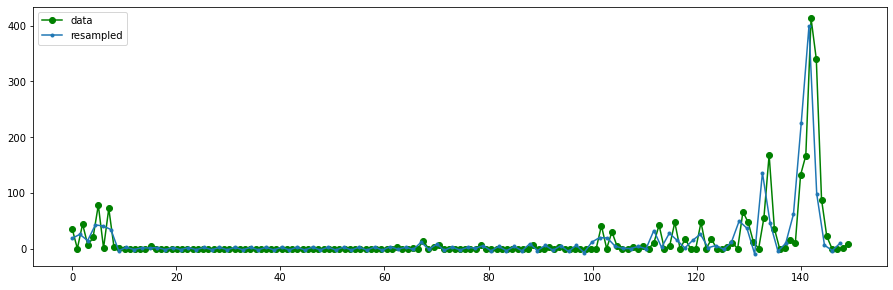

Original:   149
Resampled:   100


In [18]:
# resample 
#. Motion of specific 5 second block 

d = df['Motion'][Five_Second_On_Off['Time_Stamp'][1] : Five_Second_On_Off['Time_Stamp'][2]]


from scipy import signal
x = np.linspace(0, len(d), len(d))

# #y = np.cos(-x**2/6.0)
f = signal.resample(d, 100)
xnew = np.linspace(0, len(d), 100, endpoint=False)

# import matplotlib.pyplot as plt
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt.plot(x, d, 'go-', xnew, f, '.-')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

print('Original:  ',len(d))
print('Resampled:  ', len(f))

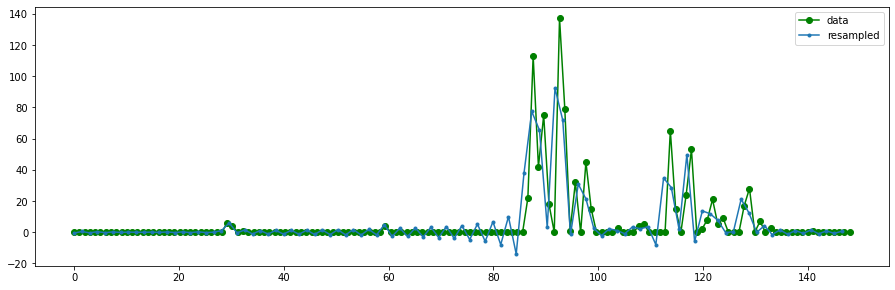

Original:   148
Resampled:   100


In [19]:
# resample 
#. Motion of specific 5 second block 

d = df['Motion'][Five_Second_On_Off['Time_Stamp'][7] : Five_Second_On_Off['Time_Stamp'][8]]


x = np.linspace(0, len(d), len(d))

# #y = np.cos(-x**2/6.0)
f = signal.resample(d, 100)
xnew = np.linspace(0, len(d), 100, endpoint=False)

# import matplotlib.pyplot as plt
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt.plot(x, d, 'go-', xnew, f, '.-')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

print('Original:  ',len(d))
print('Resampled:  ', len(f))

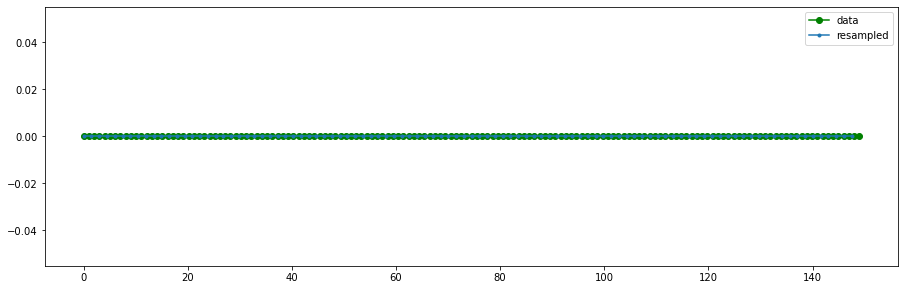

Original:   149
Resampled:   100


In [20]:
# resample 
#. Motion of specific 5 second block 

d = df['Motion'][Five_Second_On_Off['Time_Stamp'][95] : Five_Second_On_Off['Time_Stamp'][96]]



x = np.linspace(0, len(d), len(d))

# #y = np.cos(-x**2/6.0)
f = signal.resample(d, 100)
xnew = np.linspace(0, len(d), 100, endpoint=False)

# import matplotlib.pyplot as plt
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt.plot(x, d, 'go-', xnew, f, '.-')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

print('Original:  ',len(d))
print('Resampled:  ', len(f))

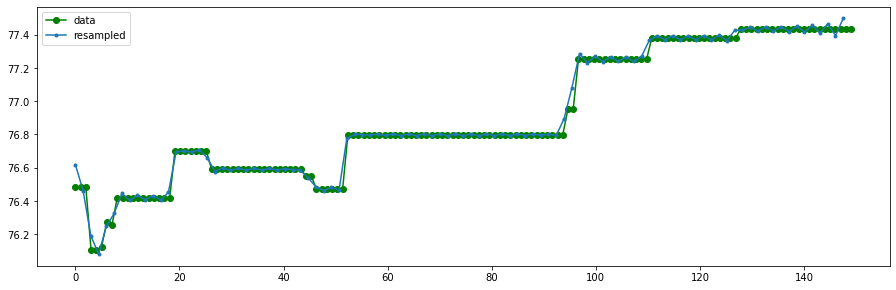

Original:   149
Resampled:   100


In [21]:
# resample 
#. Signal Light_3 (used for Infrared Detector ) of specific 5 second block 

d = df['Light_3'][Five_Second_On_Off['Time_Stamp'][9] : Five_Second_On_Off['Time_Stamp'][10]]


x = np.linspace(0, len(d), len(d))

# #y = np.cos(-x**2/6.0)
f = signal.resample(d, 100)
xnew = np.linspace(0, len(d), 100, endpoint=False)

# import matplotlib.pyplot as plt
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt.plot(x, d, 'go-', xnew, f, '.-')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

print('Original:  ',len(d))
print('Resampled:  ', len(f))

In [22]:
#  Align Timestamps
#  No adjustment for the last period of the 5s pulse because program terminates and it is likely not 5 second.  
# Data Length = 100* (# of 5 second pulse -1) + last pulse duration 
Data_Length = 100* (len(Five_Second_On_Off['Time_Stamp'])-1) + (Five_Second_On_Off['Duration'][len(Five_Second_On_Off['Time_Stamp'])-1]) #. 100 bins per block. (20 frames/second with 5 second block)

Start_Position = 0
End_Position = 99

Aligned_TimeStamp = pd.DataFrame()
Motion_label =df.keys()[0]
Aligned_TimeStamp[Motion_label] = np.zeros(Data_Length)
Light_One_label =df.keys()[1]
Aligned_TimeStamp[Light_One_label] = np.zeros(Data_Length)
Light_Two_label =df.keys()[2]
Aligned_TimeStamp[Light_Two_label] = np.zeros(Data_Length)
Light_Three_label =df.keys()[3]
Aligned_TimeStamp[Light_Three_label] = np.zeros(Data_Length)



for i in range(len(Five_Second_On_Off['Time_Stamp'])-1):
    
    # motion
    # Resample , so regardless the # of time point will be resampled back to 100 timepoints.  
    d = df[df.keys()[0]][Five_Second_On_Off['Time_Stamp'][i] : Five_Second_On_Off['Time_Stamp'][i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Aligned_TimeStamp[df.keys()[0]].loc[Start_Position: End_Position] = f
    
    #Light_1
    # Resample , so regardless the # of time point will be resampled back to 100 timepoints.  
    d = df[df.keys()[1]][Five_Second_On_Off['Time_Stamp'][i] : Five_Second_On_Off['Time_Stamp'][i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Aligned_TimeStamp[df.keys()[1]].loc[Start_Position: End_Position] = f
    
    #Light_2
    # Resample , so regardless the # of time point will be resampled back to 100 timepoints.  
    d = df[df.keys()[2]][Five_Second_On_Off['Time_Stamp'][i] : Five_Second_On_Off['Time_Stamp'][i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Aligned_TimeStamp[df.keys()[2]].loc[Start_Position: End_Position] = f
    
    #Light_3
    # Resample , so regardless the # of time point will be resampled back to 100 timepoints.  
    d = df[df.keys()[3]][Five_Second_On_Off['Time_Stamp'][i] : Five_Second_On_Off['Time_Stamp'][i+1]]
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, 100)   #. 20 frames/second for 5 seconds 
    xnew = np.linspace(0, len(d), 100, endpoint=False)
    # assign resampled data back to dataframe
    Aligned_TimeStamp[df.keys()[3]].loc[Start_Position: End_Position] = f
    

    
    
    Start_Position = Start_Position +100
    End_Position = End_Position + 100
    
#. add the last block of 5 second pulse time back in
Aligned_TimeStamp[df.keys()[0]].loc[Start_Position: len(Aligned_TimeStamp)]= df[df.keys()[0]][Five_Second_On_Off['Time_Stamp'][len(Five_Second_On_Off['Time_Stamp'])-2] : Five_Second_On_Off['Time_Stamp'][len(Five_Second_On_Off['Time_Stamp'])-1]]
Aligned_TimeStamp[df.keys()[1]].loc[Start_Position: len(Aligned_TimeStamp)]= df[df.keys()[1]][Five_Second_On_Off['Time_Stamp'][len(Five_Second_On_Off['Time_Stamp'])-2] : Five_Second_On_Off['Time_Stamp'][len(Five_Second_On_Off['Time_Stamp'])-1]]
Aligned_TimeStamp[df.keys()[2]].loc[Start_Position: len(Aligned_TimeStamp)]= df[df.keys()[2]][Five_Second_On_Off['Time_Stamp'][len(Five_Second_On_Off['Time_Stamp'])-2] : Five_Second_On_Off['Time_Stamp'][len(Five_Second_On_Off['Time_Stamp'])-1]]
Aligned_TimeStamp[df.keys()[3]].loc[Start_Position: len(Aligned_TimeStamp)]= df[df.keys()[3]][Five_Second_On_Off['Time_Stamp'][len(Five_Second_On_Off['Time_Stamp'])-2] : Five_Second_On_Off['Time_Stamp'][len(Five_Second_On_Off['Time_Stamp'])-1]]

    
print(df.keys())

print(Aligned_TimeStamp.keys())
    

Index(['Motion', 'Light_1', 'Light_2', 'Light_3'], dtype='object')
Index(['Motion', 'Light_1', 'Light_2', 'Light_3'], dtype='object')


In [23]:
# New Threshold for Aligned Data, so exported 
# Threshold to detect Signal Light_1, Light_2, Light_3

# Threshold_Aligned_Motion = 0   #. Any value below this value gets set to 0 
# Threshold_Aligned_Light_1 = 150
# Threshold_Aligned_Light_2 = 170
# Threshold_Aligned_Light_3 = 150



Aligned_Signal_Length = len(Aligned_TimeStamp)

Aligned_Signal_Motion = np.asarray( [0]*Aligned_Signal_Length)
Aligned_Signal_Motion = [i if i> Threshold_Aligned_Motion else 0 for i in Aligned_TimeStamp['Motion']] 

Aligned_Signal_Light_1 = np.asarray( [0]*Aligned_Signal_Length)
Aligned_Signal_Light_1 = [1 if i> Threshold_Aligned_Light_1 else 0 for i in Aligned_TimeStamp['Light_1']] 

Aligned_Signal_Light_2 = np.asarray( [0]*Aligned_Signal_Length)
Aligned_Signal_Light_2 = [1 if i> Threshold_Aligned_Light_2 else 0 for i in Aligned_TimeStamp['Light_2']] 

Aligned_Signal_Light_3 = np.asarray( [0]*Aligned_Signal_Length)
Aligned_Signal_Light_3 = [1 if i> Threshold_Aligned_Light_3 else 0 for i in Aligned_TimeStamp['Light_3']] 



Thresholded_Aligned_TimeStamp = pd.DataFrame()
Motion_label =df.keys()[0]
Thresholded_Aligned_TimeStamp[Motion_label] = Aligned_Signal_Motion
Light_One_label =df.keys()[1]
Thresholded_Aligned_TimeStamp[Light_One_label] = Aligned_Signal_Light_1
Light_Two_label =df.keys()[2]
Thresholded_Aligned_TimeStamp[Light_Two_label] = Aligned_Signal_Light_2
Light_Three_label =df.keys()[3]
Thresholded_Aligned_TimeStamp[Light_Three_label] = Aligned_Signal_Light_3


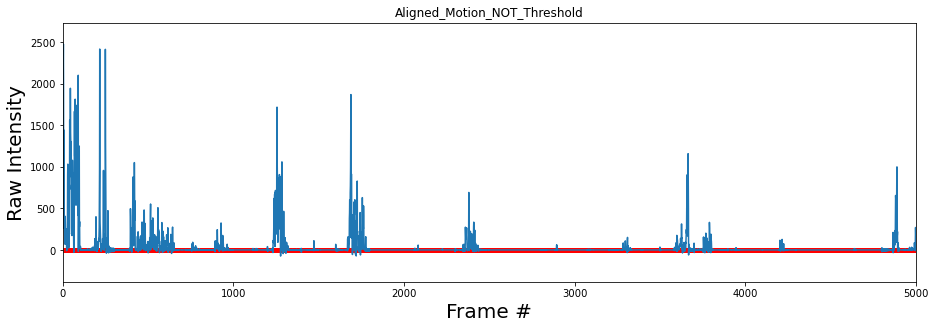

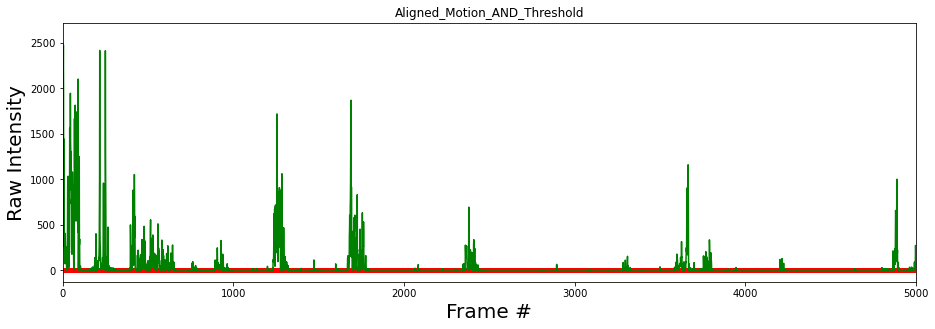

In [24]:
# Plot Motion (Aligned but not threshold)

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Aligned_Motion, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
plt_raw.plot(Aligned_TimeStamp['Motion'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Motion_NOT_Threshold', fontdict=None, loc='center')
#plt_raw.xlim(0, len(Aligned_TimeStamp)/10)
plt_raw.xlim(0, 5000)
#plt_raw.ylim(0, 50)
plt_raw.show()





# Plot Motion (Aligned and Thresholded)

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Aligned_Motion, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
plt_raw.plot(Aligned_Signal_Motion, 'green')


plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Motion_AND_Threshold', fontdict=None, loc='center')
#plt_raw.xlim(0, len(Aligned_TimeStamp)/10)
plt_raw.xlim(0, 5000)
#plt_raw.ylim(0, 50)
plt_raw.show()



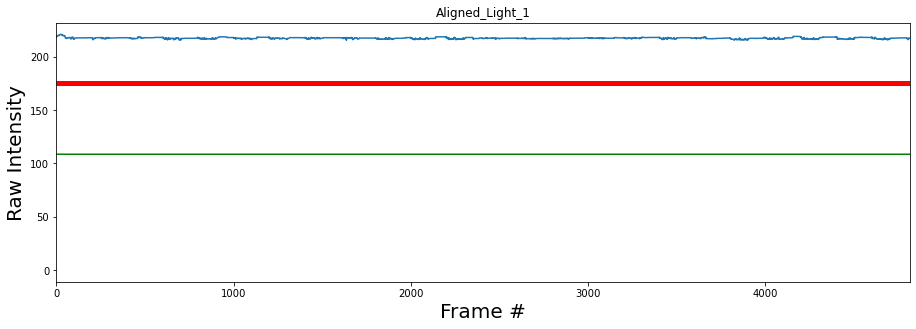

In [25]:
# Plot Light_1

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Aligned_Light_1, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
# plt_perievent_traces.xticks(np.arange(-1, (WindowBeging +WindowEnd +1), 5))
# plt_perievent_traces.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))


plt_raw.plot(Aligned_TimeStamp['Light_1'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

temp_signal_min =np.mean(Aligned_TimeStamp['Light_1'])                 
Aligned_Light_1_display = [x *temp_signal_min*0.5 for x in Aligned_Signal_Light_1]
plt_raw.plot(Aligned_Light_1_display, 'green')


plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Light_1', fontdict=None, loc='center')
plt_raw.xlim(0, len(Aligned_TimeStamp)/10)
plt_raw.show()

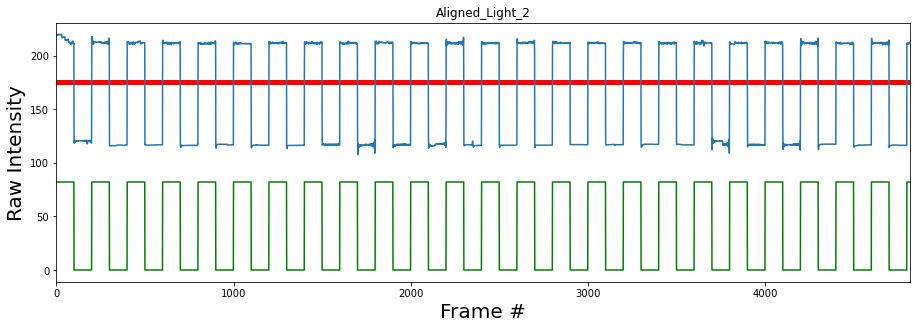

In [26]:
# Plot Light_2

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Aligned_Light_2, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
# plt_perievent_traces.xticks(np.arange(-1, (WindowBeging +WindowEnd +1), 5))
# plt_perievent_traces.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))


plt_raw.plot(Aligned_TimeStamp['Light_2'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

temp_signal_min =np.mean(Aligned_TimeStamp['Light_2'])                 
Aligned_Light_2_display = [x *temp_signal_min*0.5 for x in Aligned_Signal_Light_2]
plt_raw.plot(Aligned_Light_2_display, 'green')

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Light_2', fontdict=None, loc='center')
plt_raw.xlim(0, len(Aligned_TimeStamp)/10)
#plt_raw.xlim(len(Aligned_TimeStamp)/10*9, len(Aligned_TimeStamp))
plt_raw.show()

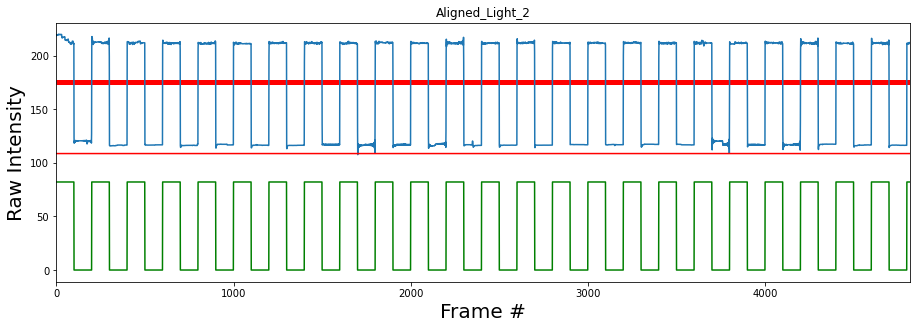

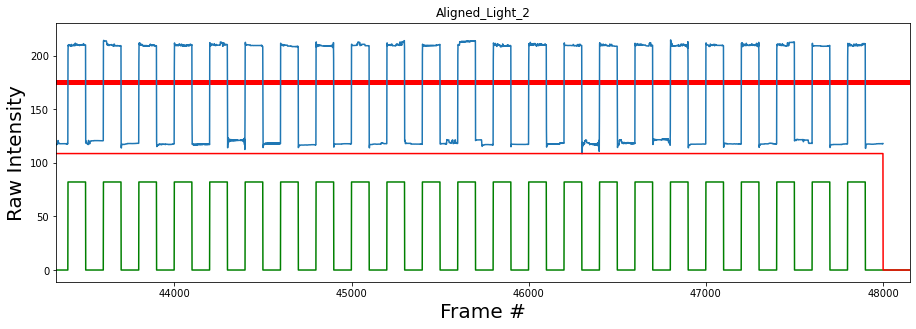

In [27]:
# Plot Light_1 Plus Light_2
############

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Aligned_Light_2, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
# plt_perievent_traces.xticks(np.arange(-1, (WindowBeging +WindowEnd +1), 5))
# plt_perievent_traces.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))


plt_raw.plot(Aligned_TimeStamp['Light_2'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)


temp_signal_min =np.mean(Aligned_TimeStamp['Light_2'])                 
Aligned_Light_2_display = [x *temp_signal_min*0.5 for x in Aligned_Signal_Light_2]
plt_raw.plot(Aligned_Light_2_display, 'green')


temp_signal_min =np.mean(Aligned_TimeStamp['Light_1'])                 
Aligned_Light_1_display = [x *temp_signal_min*0.5 for x in Aligned_Signal_Light_1]
plt_raw.plot(Aligned_Light_1_display, 'red')

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Light_2', fontdict=None, loc='center')
plt_raw.xlim(0, len(Aligned_TimeStamp)/10)
#plt_raw.xlim(len(Aligned_TimeStamp)/10*9, len(Aligned_TimeStamp))
plt_raw.show()






###############

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Aligned_Light_2, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
# plt_perievent_traces.xticks(np.arange(-1, (WindowBeging +WindowEnd +1), 5))
# plt_perievent_traces.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))


plt_raw.plot(Aligned_TimeStamp['Light_2'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)


temp_signal_min =np.mean(Aligned_TimeStamp['Light_2'])                 
Aligned_Light_2_display = [x *temp_signal_min*0.5 for x in Aligned_Signal_Light_2]
plt_raw.plot(Aligned_Light_2_display, 'green')


temp_signal_min =np.mean(Aligned_TimeStamp['Light_1'])                 
Aligned_Light_1_display = [x *temp_signal_min*0.5 for x in Aligned_Signal_Light_1]
plt_raw.plot(Aligned_Light_1_display, 'red')

plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Light_2', fontdict=None, loc='center')
#plt_raw.xlim(0, len(Aligned_TimeStamp)/10)
plt_raw.xlim(len(Aligned_TimeStamp)/10*9, len(Aligned_TimeStamp))
plt_raw.show()

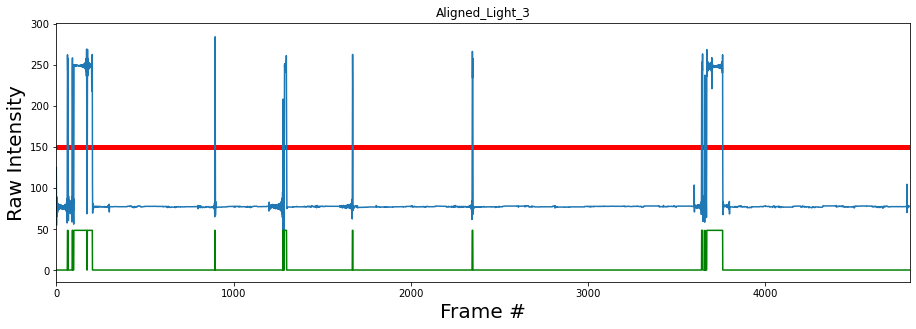

In [28]:
# Plot Light_3

# Draw Threshold Line and 
plt_raw.hlines(y= Threshold_Aligned_Light_3, xmin=0, xmax=len(df), colors='red', lw=5, label='vline_single - partial height')
# plt_perievent_traces.xticks(np.arange(-1, (WindowBeging +WindowEnd +1), 5))
# plt_perievent_traces.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))


plt_raw.plot(Aligned_TimeStamp['Light_3'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

temp_signal_min =np.mean(Aligned_TimeStamp['Light_3'])                 
Aligned_Light_3_display = [x *temp_signal_min*0.5 for x in Aligned_Signal_Light_3]
plt_raw.plot(Aligned_Light_3_display, 'green')


plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Light_3', fontdict=None, loc='center')
plt_raw.xlim(0, len(Aligned_TimeStamp)/10)
plt_raw.show()

In [29]:
# Remove The end (Non-Imaging portion ) before doing whole session alignmnet

print(Thresholded_Aligned_TimeStamp)

for i in range(len(Thresholded_Aligned_TimeStamp)-1, 1, -1):  #counts down and look for "0" in light 1 to delete row data
    if(Thresholded_Aligned_TimeStamp['Light_1'][i]== 0 ):
        Thresholded_Aligned_TimeStamp= Thresholded_Aligned_TimeStamp.drop(i)
    else:
        break # This prevents accidental removal of data in the MIDDLE of a session bc of power interruption 
print(Thresholded_Aligned_TimeStamp)   

            Motion  Light_1  Light_2  Light_3
0       937.237132        1        1        0
1      1821.664550        1        1        0
2      1892.688910        1        1        0
3      2313.907151        1        1        0
4      2476.819327        1        1        0
...            ...      ...      ...      ...
48144     0.000000        0        0        0
48145     0.000000        0        0        0
48146     0.000000        0        0        0
48147     0.000000        0        0        0
48148     0.000000        0        0        0

[48149 rows x 4 columns]
            Motion  Light_1  Light_2  Light_3
0       937.237132        1        1        0
1      1821.664550        1        1        0
2      1892.688910        1        1        0
3      2313.907151        1        1        0
4      2476.819327        1        1        0
...            ...      ...      ...      ...
47995     0.000000        1        0        0
47996     0.000000        1        0        0
47997   

In [30]:

# Whole Session Alignmnet 

WholeSession_Aligned_TimeStamp = pd.DataFrame()


for i in range(len(Thresholded_Aligned_TimeStamp.keys())):
    WholeSession_Aligned_TimeStamp[Thresholded_Aligned_TimeStamp.keys()[i]] = np.zeros(Real_Session_Len)############## change len of adjustment
    d = Thresholded_Aligned_TimeStamp[Thresholded_Aligned_TimeStamp.keys()[i]]  #############
    x = np.linspace(0, len(d), len(d))
    f = signal.resample(d, Real_Session_Len)############## change len of adjustment
    xnew = np.linspace(0, len(d), Real_Session_Len, endpoint=False)############## change len of adjustment
    WholeSession_Aligned_TimeStamp[Thresholded_Aligned_TimeStamp.keys()[i]]= f


In [31]:
# Re-appply threshold to clean up signal Light 1, 2, 3 (noise from whole session aignmnet)
# New Threshold for Aligned Data, so exported 
# Threshold to detect Signal Light_1, Light_2, Light_3

Threshold_Whole_Session_Aligned_Motion = 0   #. Any value below this value gets set to 0 
Threshold_Whole_Session_Aligned_Light_1 = 0.5   # the previous step already set this between 0 to 1 
Threshold_Whole_Session_Aligned_Light_2 = 0.5   # the previous step already set this between 0 to 1 
Threshold_Whole_Session_Aligned_Light_3 = 0.5   # the previous step already set this between 0 to 1 


WholeSession_Aligned_Signal_Length = len(WholeSession_Aligned_TimeStamp)

WholeSession_Aligned_Signal_Motion = np.asarray( [0]*WholeSession_Aligned_Signal_Length)
WholeSession_Aligned_Signal_Motion = [i if i> Threshold_Whole_Session_Aligned_Motion else 0 for i in WholeSession_Aligned_TimeStamp['Motion']] 

WholeSession_Aligned_Signal_Light_1 = np.asarray( [0]*WholeSession_Aligned_Signal_Length)
WholeSession_Aligned_Signal_Light_1 = [1 if i> Threshold_Whole_Session_Aligned_Light_1 else 0 for i in WholeSession_Aligned_TimeStamp['Light_1']] 

WholeSession_Aligned_Signal_Light_2 = np.asarray( [0]*WholeSession_Aligned_Signal_Length)
WholeSession_Aligned_Signal_Light_2 = [1 if i> Threshold_Whole_Session_Aligned_Light_2 else 0 for i in WholeSession_Aligned_TimeStamp['Light_2']] 

WholeSession_Aligned_Signal_Light_3 = np.asarray( [0]*WholeSession_Aligned_Signal_Length)
WholeSession_Aligned_Signal_Light_3 = [1 if i> Threshold_Whole_Session_Aligned_Light_3 else 0 for i in WholeSession_Aligned_TimeStamp['Light_3']] 



Twice_Aligned_TimeStamp = pd.DataFrame()
Motion_label =df.keys()[0]
Twice_Aligned_TimeStamp[Motion_label] = WholeSession_Aligned_Signal_Motion
Light_One_label =df.keys()[1]
Twice_Aligned_TimeStamp[Light_One_label] = WholeSession_Aligned_Signal_Light_1
Light_Two_label =df.keys()[2]
Twice_Aligned_TimeStamp[Light_Two_label] = WholeSession_Aligned_Signal_Light_2
Light_Three_label =df.keys()[3]
Twice_Aligned_TimeStamp[Light_Three_label] = WholeSession_Aligned_Signal_Light_3

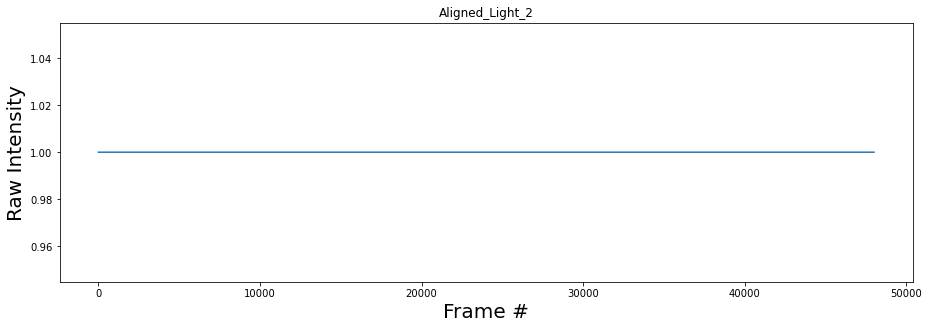

In [32]:
# Plot Light_2

# Draw Threshold Line and 
#plt_raw.hlines(y= Threshold_Aligned_Light_2, xmin=0, xmax=len(WholeSession_Aligned_TimeStamp), colors='red', lw=5, label='vline_single - partial height')
# plt_perievent_traces.xticks(np.arange(-1, (WindowBeging +WindowEnd +1), 5))
# plt_perievent_traces.yticks(np.arange(0, len(Event_Count_TimeStamps[ReferenceEvent]), 5.0))

plt_raw.plot(Twice_Aligned_TimeStamp['Light_1'])
#plt_raw.plot(Twice_Aligned_TimeStamp['Motion'])
plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)

# temp_signal_min =np.mean(WholeSession_Aligned_TimeStamp['Light_2'])                 
# Aligned_Light_2_display = [x *temp_signal_min*0.5 for x in Aligned_Signal_Light_2]
# plt_raw.plot(Aligned_Light_2_display, 'green')


plt_raw.subplots_adjust(bottom=0.1, right=2.1, top=1)
plt_raw.ylabel('Raw Intensity', size = 20)
plt_raw.xlabel('Frame #', size = 20)
plt_raw.title('Aligned_Light_2', fontdict=None, loc='center')
#plt_raw.xlim(0, len(Twice_Aligned_TimeStamp)/10)
plt_raw.show()

In [33]:
# Append file info onto export file (pad zeros, so it has the same length )
# print(df_temp.keys())
# print(len(df_temp['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)']))

t= df_temp['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)'][0:20].tolist()
for i in range(len(Twice_Aligned_TimeStamp)-len(t)):
    t.append('nan')
    
Bin = []   
for x in range(len(Twice_Aligned_TimeStamp)):
    Bin.append(x)

Twice_Aligned_TimeStamp['original_video_coor, cropped_video_coor, cropped_video_area,  x0, x1, y0, y1 (crop coordinate)']= t
Twice_Aligned_TimeStamp['Bin']= Bin


In [34]:
##Ka Added for exporting trace to excel
###################################
##Export data as CSV file
##for TimeStampExport to csv

#savefilename = os.path.join(Save_Path, ( File_Name.split("_MotionExtract_NotAlign_Step1")[0] +'_5Sec_NotAlign_Step2' + '.csv'))
savefilename = os.path.join(Save_Path, ( File_Name.split("_MotionExtract_NotAlign_Step1")[0]  + '_Aligned_Step3'+'.csv'))

Twice_Aligned_TimeStamp.to_csv(savefilename, mode='w', index=False, header=True)
        
print('Data Exported')
            


Data Exported
